# **Stock Price Prediction Using LSTM**
## Introduction
This notebook demonstrates how to use ```LSTM``` (Long Short-Term Memory) neural networks for stock price prediction and forecasting.<br>
- Historical stock price S&P500 data is downloaded from Yahoo Finance to predict 50 assets individually, choosen from S&P500 and train a LSTM model to predict tomorrow's stock price by extracting the every past 50 days closing price.<br>


### 📚 Import Necessary Libraries

In [12]:
import pandas as pd
%matplotlib inline
import numpy as np
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import yfinance as yf

## 📊 Data Collection and Preprocessing

Download 10 years S&P500 data to train the model and extract the closing price only as we will train the model based on closing price

In [13]:
df = yf.download(tickers = "^GSPC", start = "2013-01-01", end = "2024-02-10", interval = "1d", auto_adjust = True)


[*********************100%***********************]  1 of 1 completed


In [14]:
df.columns

MultiIndex([( 'Close', '^GSPC'),
            (  'High', '^GSPC'),
            (   'Low', '^GSPC'),
            (  'Open', '^GSPC'),
            ('Volume', '^GSPC')],
           names=['Price', 'Ticker'])

📏 Scale the data using MinMaxScaler to normalize the data and make it easier for the model to train on the data.

In [15]:
df = df.reset_index()['Close']

In [16]:
scaler = MinMaxScaler(feature_range=(0,1))
df = scaler.fit_transform(np.array(df).reshape(-1,1))

✂️ Split into train, Validation and test data

In [17]:
training_size = int(len(df) * 0.75)
validation_size = int(len(df) * 0.15)
test_size = len(df) - training_size - validation_size

train_data = df[0:training_size, :]
validation_data = df[training_size:training_size+validation_size, :]
test_data = df[training_size+validation_size:len(df), :]

In [18]:
train_data.shape, validation_data.shape , test_data.shape

((2097, 1), (419, 1), (280, 1))

Create feature data

In [19]:
def process_data(data,time_step=1):
    xtrain,ytrain =[],[]
    for i in range(len(data)-time_step-1):
        xtrain.append(data[i:(i+time_step),0])
        ytrain.append(data[i+time_step,0])
    return np.array(xtrain),np.array(ytrain)

In [20]:
xtrain,ytrain = process_data(train_data,50)
xval,yval = process_data(validation_data,50)
xtest,ytest = process_data(test_data,50)

In [21]:
xtrain.shape,xval.shape

((2046, 50), (368, 50))

In [22]:
xtest.shape,ytest.shape

((229, 50), (229,))

Reshape input to be 3D [samples, time steps, target] which is required for LSTM

In [23]:
X_train = xtrain.reshape(xtrain.shape[0],xtrain.shape[1],1)
X_test = xtest.reshape(xtest.shape[0],xtest.shape[1],1)
X_val = xval.reshape(xval.shape[0],xval.shape[1],1)
X_train.shape,X_test.shape,X_val.shape

((2046, 50, 1), (229, 50, 1), (368, 50, 1))

In [24]:
model = Sequential()
model.add(LSTM(128,return_sequences=True,input_shape=(50,1)))
model.add(LSTM(64,return_sequences=True))
model.add(LSTM(50))
model.add(Dropout(0.2))  #Dropout layer to prevent overfitting
model.add(Dense(25))
model.add(Dense(1))      #Output layer with 1 neuron as we are predicting one stock price
model.compile(loss='mean_squared_error',optimizer=Adam())

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Create callbacks to stop the training if the model is not learning and to save the best model

In [25]:
checkpoint_path = "/content/lstm_12_p50_ckp_13_24_e150.h5"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=False,
                                      monitor="val_loss",
                                      save_best_only=True)

early_stopping = EarlyStopping(monitor = "val_loss",
                               patience = 10,
                               restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=1e-5)

In [26]:
history = model.fit(X_train,ytrain,validation_data=(X_val,yval),epochs=150,batch_size=32,verbose=1,
                     callbacks=[ early_stopping,
                                checkpoint_callback])
                    #             reduce_lr])

Epoch 1/150
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0157

64/64 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - loss: 0.0151 - val_loss: 0.0037
Epoch 2/150
63/64 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 9.7357e-04

64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 9.7622e-04 - val_loss: 0.0023
Epoch 3/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0011 - val_loss: 0.0046
Epoch 4/150
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 8.9370e-04

64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 8.9082e-04 - val_loss: 0.0013
Epoch 5/150
60/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.2306e-04

64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 6.3072e-04 - val_loss: 0.0012
Epoch 6/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 8.1417e-04 - val_loss: 0.0018
Epoch 7/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 7.8521e-04 - val_loss: 0.0016
Epoch 8/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 6.0772e-04 - val_loss: 0.0021
Epoch 9/150
60/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.0328e-04

64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 5.0514e-04 - val_loss: 0.0012
Epoch 10/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 5.2642e-04 - val_loss: 0.0013
Epoch 11/150
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.0789e-04

64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 5.0660e-04 - val_loss: 9.9102e-04
Epoch 12/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 4.0736e-04 - val_loss: 0.0011
Epoch 13/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 5.1124e-04 - val_loss: 0.0012
Epoch 14/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 5.4753e-04 - val_loss: 0.0014
Epoch 15/150
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.8145e-04

64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.8242e-04 - val_loss: 7.8093e-04
Epoch 16/150
59/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.6612e-04

64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 3.6979e-04 - val_loss: 7.7008e-04
Epoch 17/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.0651e-04 - val_loss: 7.7416e-04
Epoch 18/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.8850e-04 - val_loss: 0.0012
Epoch 19/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 3.7175e-04 - val_loss: 0.0016
Epoch 20/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 3.5781e-04 - val_loss: 8.7206e-04
Epoch 21/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.8063e-04

64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 3.8091e-04 - val_loss: 7.1892e-04
Epoch 22/150
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.9069e-04

64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.8884e-04 - val_loss: 7.1181e-04
Epoch 23/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.2421e-04

64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 3.2483e-04 - val_loss: 7.0038e-04
Epoch 24/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 3.4419e-04 - val_loss: 0.0012
Epoch 25/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 3.6705e-04 - val_loss: 0.0015
Epoch 26/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.8840e-04 - val_loss: 7.6148e-04
Epoch 27/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.2770e-04 - val_loss: 7.2789e-04
Epoch 28/150
59/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.8315e-04

64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.8252e-04 - val_loss: 6.0448e-04
Epoch 29/150
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.2141e-04

64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.2298e-04 - val_loss: 5.8061e-04
Epoch 30/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.8018e-04 - val_loss: 6.4804e-04
Epoch 31/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.9568e-04 - val_loss: 0.0030
Epoch 32/150
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.1995e-04

64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.1835e-04 - val_loss: 5.4095e-04
Epoch 33/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.5300e-04 - val_loss: 5.4807e-04
Epoch 34/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.3236e-04 - val_loss: 6.7285e-04
Epoch 35/150
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2.8332e-04

64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 2.8511e-04 - val_loss: 5.1114e-04
Epoch 36/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 2.9065e-04 - val_loss: 0.0015
Epoch 37/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.6470e-04 - val_loss: 5.2290e-04
Epoch 38/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 3.0377e-04 - val_loss: 7.6336e-04
Epoch 39/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 3.1289e-04 - val_loss: 8.2552e-04
Epoch 40/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.4001e-04 - val_loss: 5.3693e-04
Epoch 41/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.2470e-04 - val_loss: 5.5579e-04
Epoch 42/150
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.0563e-04

64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.0474e-04 - val_loss: 4.5699e-04
Epoch 43/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.9192e-04 - val_loss: 7.4896e-04
Epoch 44/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.1228e-04 - val_loss: 9.2828e-04
Epoch 45/150
63/64 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.0257e-04

64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.0173e-04 - val_loss: 4.4399e-04
Epoch 46/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 2.6128e-04 - val_loss: 6.0221e-04
Epoch 47/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 2.7569e-04 - val_loss: 0.0017
Epoch 48/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.5652e-04 - val_loss: 8.8475e-04
Epoch 49/150
59/64 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.5837e-04

64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.6097e-04 - val_loss: 4.0298e-04
Epoch 50/150
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.9655e-04

64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.9674e-04 - val_loss: 3.7623e-04
Epoch 51/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.7582e-04 - val_loss: 9.0121e-04
Epoch 52/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.0020e-04 - val_loss: 0.0014
Epoch 53/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.9974e-04 - val_loss: 4.0902e-04
Epoch 54/150
60/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.8897e-04

64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.8690e-04 - val_loss: 3.2990e-04
Epoch 55/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.6292e-04 - val_loss: 3.9723e-04
Epoch 56/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 2.9694e-04 - val_loss: 4.1635e-04
Epoch 57/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 2.5286e-04 - val_loss: 4.1860e-04
Epoch 58/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.6838e-04 - val_loss: 4.8407e-04
Epoch 59/150
59/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.4597e-04

64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.4658e-04 - val_loss: 3.1821e-04
Epoch 60/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.8247e-04 - val_loss: 7.2249e-04
Epoch 61/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.9265e-04 - val_loss: 6.4348e-04
Epoch 62/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.6614e-04 - val_loss: 4.1771e-04
Epoch 63/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.0187e-04 - val_loss: 3.8526e-04
Epoch 64/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.5998e-04 - val_loss: 6.3350e-04
Epoch 65/150
60/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.4802e-04

64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 2.4855e-04 - val_loss: 3.0153e-04
Epoch 66/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.2101e-04 - val_loss: 3.0194e-04
Epoch 67/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.6584e-04 - val_loss: 4.3364e-04
Epoch 68/150
62/64 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.7272e-04

64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 2.7262e-04 - val_loss: 2.7851e-04
Epoch 69/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 2.6010e-04 - val_loss: 8.6364e-04
Epoch 70/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 2.7611e-04 - val_loss: 3.8607e-04
Epoch 71/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.7738e-04 - val_loss: 2.9255e-04
Epoch 72/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.5627e-04 - val_loss: 2.9090e-04
Epoch 73/150
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.5699e-04

64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.5692e-04 - val_loss: 2.6415e-04
Epoch 74/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.9319e-04 - val_loss: 2.8449e-04
Epoch 75/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.4148e-04 - val_loss: 3.4477e-04
Epoch 76/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.2012e-04 - val_loss: 2.8641e-04
Epoch 77/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.2287e-04

64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.2244e-04 - val_loss: 2.5790e-04
Epoch 78/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.3964e-04 - val_loss: 5.6085e-04
Epoch 79/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.3819e-04 - val_loss: 3.4787e-04
Epoch 80/150
59/64 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.5530e-04

64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.5455e-04 - val_loss: 2.5446e-04
Epoch 81/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 2.5014e-04 - val_loss: 2.7037e-04
Epoch 82/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.3354e-04 - val_loss: 4.1686e-04
Epoch 83/150
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.3489e-04

64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.3602e-04 - val_loss: 2.5188e-04
Epoch 84/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.8141e-04 - val_loss: 2.5838e-04
Epoch 85/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.4495e-04 - val_loss: 6.4816e-04
Epoch 86/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.8959e-04 - val_loss: 3.4932e-04
Epoch 87/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.3745e-04 - val_loss: 4.7333e-04
Epoch 88/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.1629e-04 - val_loss: 2.6032e-04
Epoch 89/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.0057e-04 - val_loss: 8.6970e-04
Epoch 90/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.6571e-04 - val_loss: 2.5572e-04
Epoch 91/150
60/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.3580e-04

64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.3572e-04 - val_loss: 2.4989e-04
Epoch 92/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.3047e-04 - val_loss: 6.9581e-04
Epoch 93/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 2.7686e-04 - val_loss: 6.7740e-04
Epoch 94/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 2.2744e-04 - val_loss: 4.9116e-04
Epoch 95/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.3968e-04 - val_loss: 3.7153e-04
Epoch 96/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.1381e-04 - val_loss: 3.5567e-04
Epoch 97/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.2432e-04 - val_loss: 5.5305e-04
Epoch 98/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.6993e-04 - val_loss: 2.6573e-04
Epoch 99/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.4593e-04 - val_loss: 4.0392e-04
Epoch 100/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.4742e-04 - val_loss: 7.7225e-04
Epoch 101/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 

Epoch 1/150<br>
64/64 [==============================] - 19s 183ms/step - loss: 0.0067 - val_loss: 0.0016<br>
Epoch 2/150<br>
64/64 [==============================] - 10s 158ms/step - loss: 0.0011 - val_loss: 0.0017<br>
........<br>

64/64 [==============================] - 10s 158ms/step - loss: 2.6924e-04 - val_loss: 2.9811e-04<br>
Epoch 91/150<br>
64/64 [==============================] - 9s 139ms/step - loss: 2.4702e-04 - val_loss: 3.1734e-04<br>
Epoch 92/150<br>
64/64 [==============================] - 10s 159ms/step - loss: 2.8283e-04 - val_loss: 3.7337e-04<br>

**The output is trancaated for better readability**

## Model Evaluation


Plot the learning curve

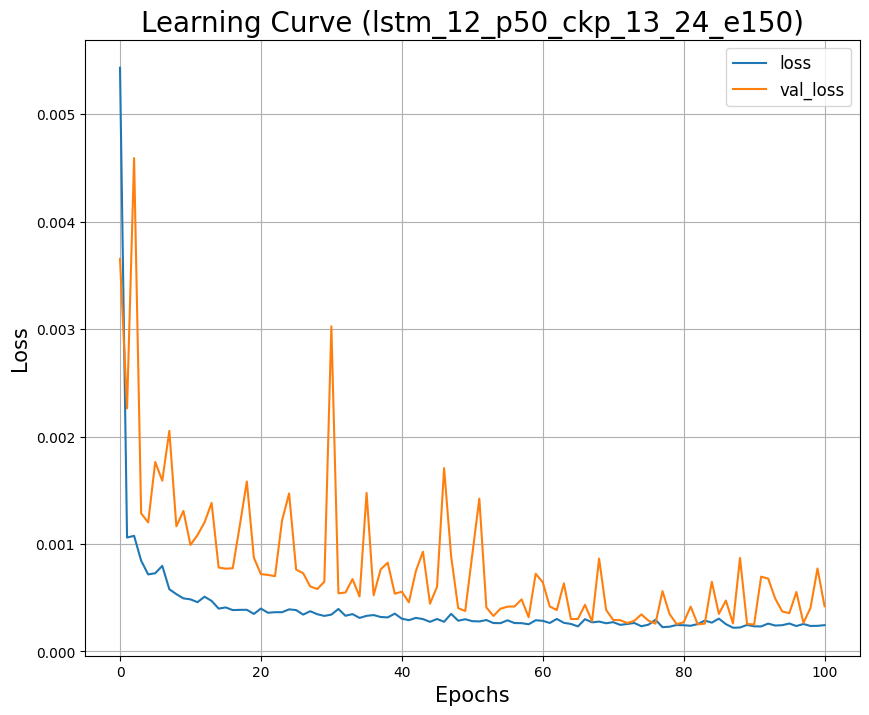

In [27]:
result = pd.DataFrame(history.history)
result.plot(figsize=(10,8))
plt.title("Learning Curve (lstm_12_p50_ckp_13_24_e150)", fontsize=20)
plt.grid()
plt.legend(fontsize=12)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.show()


- ↗️ The above learning curve shows that the model is learning well and both the train and validation loss is decreasing with each epoch.
- The gap between the training loss and validation loss appears to be relatively small but there are some fluctuations in the validation curve.

Predict the test data 🔮

In [28]:
train_predict = model.predict(X_train)
val_predict = model.predict(X_val)
test_predict = model.predict(X_test)

64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


Inverse the scaled data to get the actual stock price

In [29]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
val_predict = scaler.inverse_transform(val_predict)

Evaluate the model performance using RMSE

In [30]:
math.sqrt(mean_squared_error(ytrain,train_predict))

2539.581183865194

In [31]:
math.sqrt(mean_squared_error(ytest,test_predict))

4410.060923589192

Plot the train, validation and test data and test prediction in the same plot 📉

In [32]:
# shift train predictions for plotting
look_back = 50
trainPredictPlot = np.empty_like(df)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict) + look_back, :] = train_predict

# shift validation predictions for plotting
valPredictPlot = np.empty_like(df)
valPredictPlot[:, :] = np.nan
valPredictPlot[len(train_predict) + look_back + 1:len(train_predict) + look_back + len(val_predict) + 1, :] = val_predict

# shift test predictions for plotting
testPredictPlot = np.empty_like(df)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict) + len(val_predict) + (look_back * 3) + 1:len(train_predict) + len(val_predict) + (look_back * 3) + len(test_predict) + 1, :] = test_predict


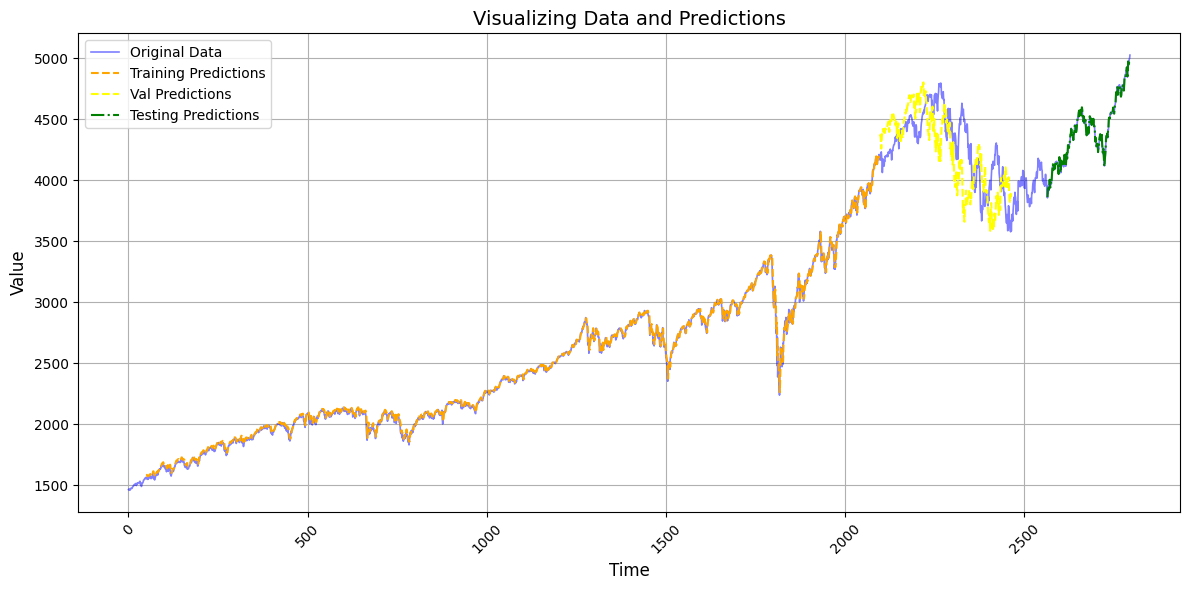

In [33]:
plt.figure(figsize=(12, 6))

# Plot original data
plt.plot(scaler.inverse_transform(df), label='Original Data', color='blue', linewidth=1.2,alpha=0.5)

# Plot training predictions
plt.plot(trainPredictPlot, label='Training Predictions', color='orange', linewidth=1.5, linestyle='--')
plt.plot(valPredictPlot, label='Val Predictions', color='yellow', linewidth=1.5, linestyle='--')
# Plot testing predictions
plt.plot(testPredictPlot, label='Testing Predictions', color='green', linewidth=1.5, linestyle='-.')

plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Visualizing Data and Predictions')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.title('Visualizing Data and Predictions', fontsize=14)
plt.tight_layout()
plt.show()

↗️ The blue line represents the actual stock price and green line represents the predicted stock price.<br>
From this plot, we can see that the model is able to predict the stock price with a good accuracy as the green line is very close to the blue line and overlapping with it.

Plot the test data and test prediction in the same plot

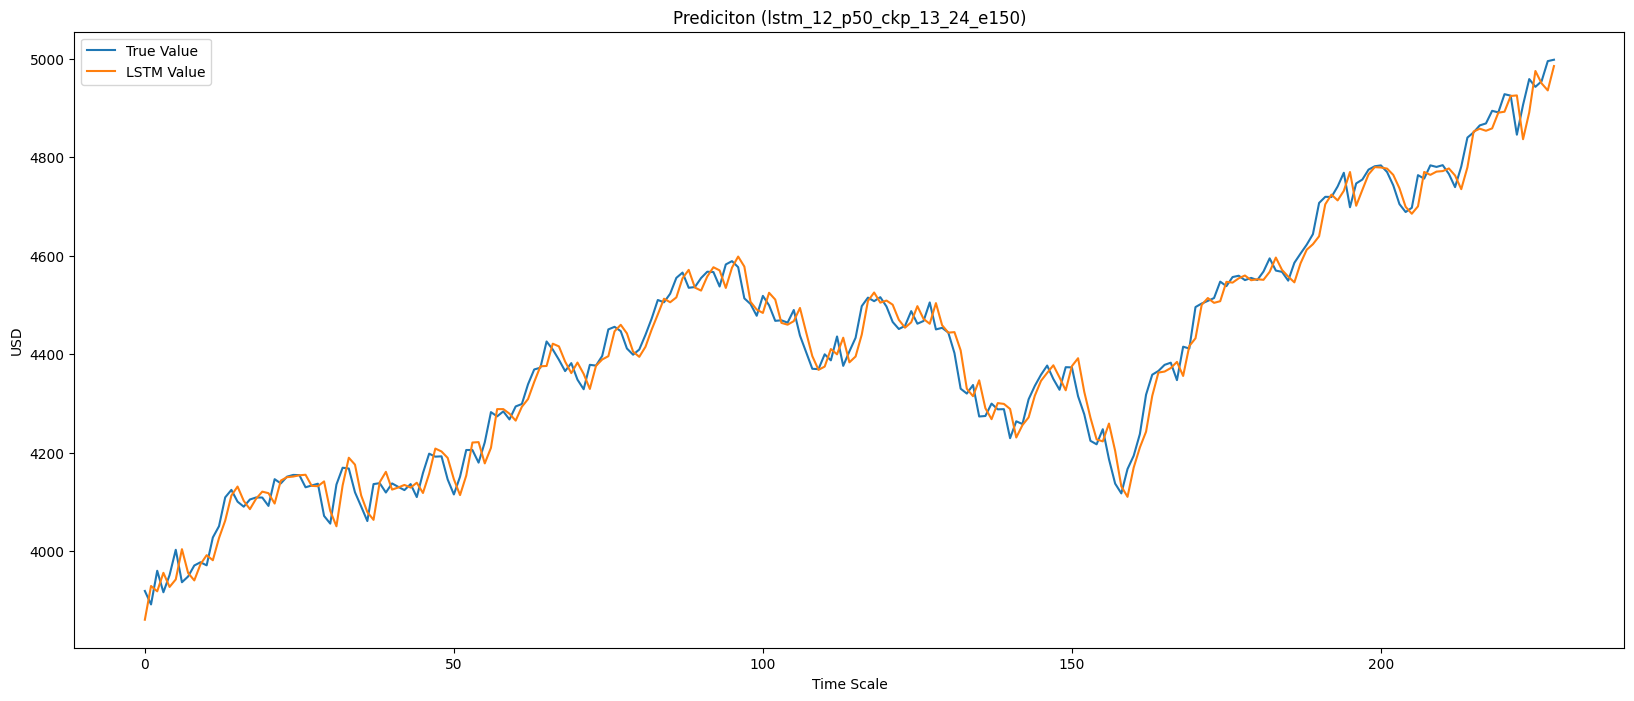

In [34]:
ytest_inv = scaler.inverse_transform(np.array(ytest).reshape(-1,1))
plt.figure(figsize=(20, 8))
plt.plot(ytest_inv, label="True Value")
plt.plot(test_predict, label="LSTM Value")
plt.title("Prediciton (lstm_12_p50_ckp_13_24_e150)")
plt.xlabel("Time Scale")
plt.ylabel("USD")
plt.legend()
plt.show()

##  Decision Point

↗️ In the diagram above, the blue line represents the actual stock price and orange line represents the predicted stock price.<br>
- From this plot, we can see that the lstm predicted value is higher than the actual value when there is a downward trend and lower than the actual value when there is an upward trend.<br>
- Although the model is not predicting the exact stock price but it can follow the trend well.<br>
- And the most interesting thing is that we can use it as a filter like as moving average with other Technical Indicators to generate buy and sell signals during backtesting.<br>
- We will apply the lstm model during backtesting in which the strategy will buy the stock when the predicted price is lower than the actual price and sell the stock when the predicted price is higher than the actual price sothat we can close positions with higher price when the model will predict there will be a down trend and take profit.<br>

###  Future Work
- The LSTM model underperforming while predicting based on past 100 and 150 days and coudn't keep the memory of longer sequences. LSTM may suffer from vanishing gradients and can be improved with `Attention mechanisms`, `Stacking more layers` or ```Bidirectional LSTMs``` etc.🔧
- Tune the hyperparameters and the model architecture

### Model Inference time

In [35]:
import time
single_sample = X_test[:1]
start_time = time.time()
single_prediction = model.predict(single_sample)
end_time = time.time()

inference_time = end_time - start_time
print(f"Inference time for single prediction: {inference_time:.6f} seconds")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Inference time for single prediction: 0.081827 seconds


10 predictions per second